# Stéréovision

![Suzanne](main.png)

La stéréovision est une discipline qui s’occupe de reconstruire des informations 3D à partir d’images. Ppour que la reconstruction d’un point soit possible, il faut plusieurs images de ce point. Ces images doivent être prises de points de vue différents. L’étape clé de la reconstruction, qui pose souvent problème, est d’indentifier l’image du point à reconstruire dans chacune des vues.

## Géométrie épipolaire

La géométrie épipolaire fait intervenir deux caméras. La géométrie épipolaire décrit les propriétés géométriques entre deux vues d’une même scène et ne dépend que des paramètres intrinsèques des caméras et de leurs positions relatives. Elle fournit, en particulier, la contrainte épipolaire, qui nous sera très utile pour produire les appariements entre vues.

## La matrice fondamentale

![Géométrie épipolaire - Sanyam Kapoor](https://i.imgur.com/GbafZIY.png)

Imaginons que nous ayons deux images, droite et gauche, de l’espace monde. Prenons un point $\vec{x}$ dans l’espace image droit. Le point $\vec{X}$ de l’espace monde, dont $\vec{x}$ est l’image, peut se trouver n’importe où sur la droite passant par $\vec{x}$ et le centre optique de la caméra de droite. Nous appellerons cette droite, le rayon retro-projeté de $\vec{x}$. Notons $\vec{x}'$ l’image de $\vec{X}$ dans l’espace image gauche. Le lieu de $\vec{x}'$ est donc la droite image du rayon retro-projeté de $\vec{x}$. Cette droite est appelée ligne épipolaire et notée $\vec{l}'$. La ligne épipolaire passe par l’épipole $\vec{e}'$, image du centre optique de la caméra de droite.

En géométrie projective 2D, une droite d’équation $ax+by+c = 0$ est représentée par un vecteur à trois composantes $(a, b, c)^T$ définies à un facteur près. On a donc la relation suivante:

>Le point $\vec{x}$ appartient à la droite $\vec{l}$ si et seulement si $x^T\vec{l} = 0$.

De plus, en géométrie projective 2D, les relations remarquables suivantes sont valables:

- L’intersection de deux lignes $l$ et $l'$ est donnée par $x = l \times l'$,
- La droite passant par deux points $x$ et $x'$ est donnée par $l = x \times x'$.

Notons que le produit vectoriel peut être écrit comme un produit de matrice $x \times y = [x]_\times y$ où

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

Pour trouver l’équation de la ligne épipolaire dans l’espace image gauche, il nous suffit donc de trouver les coordonnées de deux points de cette ligne. Le premier est l’image $P'\vec{C}$ du centre optique $\vec{C}$ de la caméra de droite où $P'$ est la matrice de projection de la caméra de gauche. Le deuxième est $P'P^{+}\vec{x}$ où $P^{+}$ est la pseudo inverse de la matrice de projection $P$ de la caméra de droite. La ligne épipolaire a donc pour équation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ avec $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ est appelée matrice fondamentale.

Comme la ligne épipolaire $\vec{l}' = F\vec{x}$ est le lieu de $\vec{x}'$, $\vec{x}'$ appartient donc à $\vec{l}'$ ce qui conduit à la contrainte épipolaire :

>**La matrice fondamentale est telle que pour toute paire de points se correspondant $\vec{x} \leftrightarrow \vec{x}'$ dans les deux images, on a $\vec{x}'^{T}F\vec{x} = 0$.**

## Calcul de la matrice fondamentale

La matrice fondamentale $F$ a sept degrés de liberté. Elle possède neuf composantes mais celles-ci sont définies à un facteur d’échelle près, ce qui enlève un degré de liberté. De plus, la matrice $F$ est une matrice singulière ($det(F) = 0$) ce qui nous fait bien sept degrés de liberté. Il nous faut donc sept correspondances minimum pour calculer $F$. L’équation $x'^{T}_iFx_i = 0$ et les sept correspondances nous permettent d’écrire un système d’équations de la forme $Af = 0$, où $f$ est le vecteur qui contient les composantes de la matrice $F$. Admettons que $A$ soit une matrice 7×9 de rang 7. La solution générale de $Af = 0$ peut s’écrire $\alpha f_1 + (1−\alpha) f_2$ où $f_1$ et $f_2$ sont deux solutions particulières indépendantes de $Af = 0$. On utilise ensuite la contrainte de singularité $det(\alpha F_1 + (1 − \alpha)F_2) = 0$ pour déterminer $\alpha$. La contrainte de singularité donnant lieu à une équation du troisième degré, on pourra avoir une ou trois solutions pour $F$.

## OpenCV

En pratique vous allez utiliser la bibliothèque OpenCV. En python, vous avez accès à ses fonctions grâce au module `cv2`.

Vous pouvez trouver de l'aide concernant les fonctions de calibration et de reconstruction à la page https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html

## Objectif

Dans le zip de l'énoncé vous trouverez deux séquences d'images prise par deux caméras pendant le balayage d'un objet par un plan laser.

![Laser](scanRight/scan0010.png)

Vous trouverez également des prises de vue d'un damier dans différentes position qui vous aideront à calibrer vos caméras.

![Damier](chessboards/c1Right.png)

Le but est de reconstruire en 3D l'objet scanné.

In [2]:
#On lance toutes les librairies que l'on va utiliser
### glob c'est pour prendre toutes les images d'un fichier
###mathutils c'est pour utiliser "Vector"
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import imageio
import mathutils as mt

from mpl_toolkits.mplot3d import Axes3D

## Calibration de la Camera (avec calibrateCamera)

## Calibration de caméra
La calibration de caméra consiste à trouver la matrice de projection d'une caméra en partant de points dans une image dont on connait les coordonnées dans l'espace monde.

Nous allons ici réaliser une calibration dans un cas simplifié. Les coordonnées mondes seront en 2D. C'est un cas très utile en pratique lorsqu'on s'intéresse à des objets qui évoluent sur un plan.

Lorsque les coordonnées sont en 2D, la matrice de projection devient une matrice $3 \times 3$ et comme cette matrice est définie à un facteur près, il n'y a que 8 paramètres indépendants. Cela revient à dire que l'on peut fixer une des composante de la matrice. On fixe en général le coin inférieur droit à 1.

$$\begin{pmatrix} sx_i \\ sy_i \\ s \end{pmatrix} = \begin{pmatrix}m_{11} & m_{12} & m_{13} \\ m_{21} & m_{22} & m_{23} \\ m_{31} & m_{32} & 1 \end{pmatrix}\begin{pmatrix} x_w \\ y_w \\ 1 \end{pmatrix}$$

Les coordonnées images sont elles aussi définies à un facteur près $s$.

Lorsqu'on connait les coordonnées d'un point dans l'image et dans le monde, on peut écrire les équations suivantes

$$
\begin{array}{ll}
& \begin{cases}
sx_i & = m_{11}x_w + m_{12}y_w + m_{13} \\
sy_i & = m_{21}x_w + m_{22}y_w + m_{23} \\
s & = m_{31}x_w + m_{32}y_w + 1
\end{cases} \\
\Leftrightarrow & \begin{cases}
0 & = (m_{11} - m_{31}x_i)x_w + (m_{12} - m_{32}x_i)y_w + (m_{13}-x_i) \\
0 & = (m_{21} - m_{31}y_i)x_w + (m_{22} - m_{32}y_i)y_w + (m_{23}-y_i)
\end{cases} \\
\Leftrightarrow & \begin{cases}
x_i &= &x_wm_{11} &+ y_wm_{12} &+ m_{13} &+ 0m_{21} &+ 0m_{22} &+ 0m_{23} &- x_ix_wm_{31} &- x_iy_wm_{32} \\
y_i &= &0m_{11} &+ 0m_{12} &+ 0m_{13} &+ x_wm_{21} &+ y_wm_{22} &+ m_{23} &- y_ix_wm_{31} &- y_iy_wm_{32}
\end{cases} \\
\Leftrightarrow & \begin{pmatrix}x_i \\ y_i\end{pmatrix}=\begin{pmatrix}x_w & y_w & 1 & & & & -x_ix_w & -x_iy_w \\ & & & x_w & y_w & 1 & -y_ix_w & -y_iy_w \end{pmatrix}\begin{pmatrix}m_{11} \\ m_{12} \\ m_{13} \\ m_{21} \\ m_{22} \\ m_{23} \\ m_{31} \\ m_{32} \end{pmatrix}
\end{array}
$$

Nous avons donc 2 équations par point. Comme nous avons 8 inconnues pour connaitre la matrice de projection, il nous faut 4 points:

$$\begin{pmatrix}x_{1i} \\ y_{1i} \\ x_{2i} \\ y_{2i} \\ x_{3i} \\ y_{3i} \\ x_{4i} \\ y_{4i} \end{pmatrix}=\begin{pmatrix}x_{1w} & y_{1w} & 1 & & & & -x_{1i}x_{1w} & -x_{1i}y_{1w} \\ & & & x_{1w} & y_{1w} & 1 & -y_{1i}x_{1w} & -y_{1i}y_{1w} \\ x_{2w} & y_{2w} & 1 & & & & -x_{2i}x_{2w} & -x_{2i}y_{2w} \\ & & & x_{2w} & y_{2w} & 1 & -y_{2i}x_{2w} & -y_{2i}y_{2w} \\ x_{3w} & y_{3w} & 1 & & & & -x_{3i}x_{3w} & -x_{3i}y_{3w} \\ & & & x_{3w} & y_{3w} & 1 & -y_{3i}x_{3w} & -y_{3i}y_{3w} \\ x_{4w} & y_{4w} & 1 & & & & -x_{4i}x_{4w} & -x_{4i}y_{4w} \\ & & & x_{4w} & y_{4w} & 1 & -y_{4i}x_{4w} & -y_{4i}y_{4w} \end{pmatrix}\begin{pmatrix}m_{11} \\ m_{12} \\ m_{13} \\ m_{21} \\ m_{22} \\ m_{23} \\ m_{31} \\ m_{32} \end{pmatrix}$$

$$\begin{pmatrix}m_{11} \\ m_{12} \\ m_{13} \\ m_{21} \\ m_{22} \\ m_{23} \\ m_{31} \\ m_{32} \end{pmatrix}=\begin{pmatrix}x_{1w} & y_{1w} & 1 & & & & -x_{1i}x_{1w} & -x_{1i}y_{1w} \\ & & & x_{1w} & y_{1w} & 1 & -y_{1i}x_{1w} & -y_{1i}y_{1w} \\ x_{2w} & y_{2w} & 1 & & & & -x_{2i}x_{2w} & -x_{2i}y_{2w} \\ & & & x_{2w} & y_{2w} & 1 & -y_{2i}x_{2w} & -y_{2i}y_{2w} \\ x_{3w} & y_{3w} & 1 & & & & -x_{3i}x_{3w} & -x_{3i}y_{3w} \\ & & & x_{3w} & y_{3w} & 1 & -y_{3i}x_{3w} & -y_{3i}y_{3w} \\ x_{4w} & y_{4w} & 1 & & & & -x_{4i}x_{4w} & -x_{4i}y_{4w} \\ & & & x_{4w} & y_{4w} & 1 & -y_{4i}x_{4w} & -y_{4i}y_{4w} \end{pmatrix}^{-1}\begin{pmatrix}x_{1i} \\ y_{1i} \\ x_{2i} \\ y_{2i} \\ x_{3i} \\ y_{3i} \\ x_{4i} \\ y_{4i} \end{pmatrix}$$

./chessboards\c1Left.png


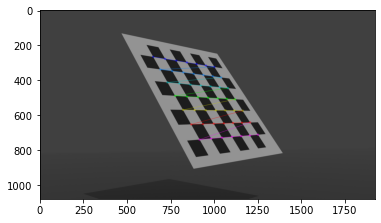

./chessboards\c1Right.png


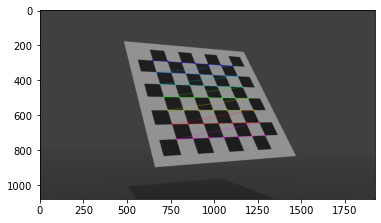

./chessboards\c2Left.png


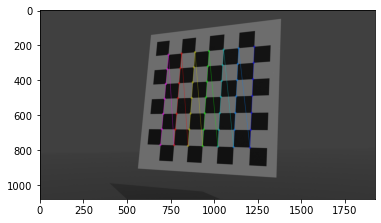

./chessboards\c2Right.png


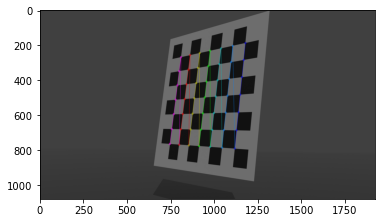

./chessboards\c4Left.png


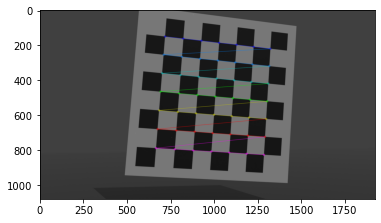

./chessboards\c4Right.png


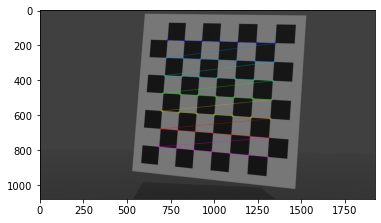

In [3]:
### On va calibrer la caméra à l'aide des échequiers.

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) #détermine la termination criteria de opencv.
### 30 est le nb max d'iteration, 0,001 est la précision et le premier terme est le type.

objp = np.zeros((7*7,3), np.float32) #liste de 0 qui contiendra le nombre d'intersections pour chaque chessboard un différent (7*7 car 7 intersections hor*7intersection vert.)
#une matrice de 7 sur 7 avec que des 0
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2) #on la modifie pour quu'elle aille de (0,0,0) à (7,7,0)
# on remplit la matrice de 0 à 7 dans les deux sens 
## On crée mtn deux arrays, un pour les points dans 'la réalité ce qu'on connait et un array avec les points sur l'image en 2D
objpoints = [] # Les points dans la réalité donc en 3D (de toutes les images !)
imgpoints = [] # Les points sur l'image plan (en 2D)(correspondant au objpoints)

FichierImages = glob.glob('./chessboards/*.png') #On prend toutes les images dans chessboards

for fname in FichierImages: #Image par image
    img = cv2.imread(fname) #On va chercher l'image
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)# On transforme l'image en noir et blanc (gray)

    # On cherche les intersections.
    ret, corners = cv2.findChessboardCorners(gray, (7,7),None) 

    # corners contient les coordonnées et ret contient une valeur non-nul si la fonction a bien trouvé les intersections
    if ret == True:
        objpoints.append(objp)#Nouvelle image donc nouveau set de coordonnées qu'on rajoute à l'array des points dans la réalité
        imgpoints.append(corners)#On rajoute les coordonnées dans le 2D qu'on a calculé avec findChessboardCorners()
        
        ##On dessine les images avec les points choisis pour voir que ca a bien été fait
        img = cv2.drawChessboardCorners(img, (7,7), corners, ret)
        print(fname)
        plt.imshow(img)
        plt.show()
        cv2.waitKey(10)
    

#fonction de openCV pour calibrer la caméra. les inputs c'est les coord reel en 3D avec les coord plan, et la taille. 
#Les output, ret confirme si ca a marché, mtx c'est la matrice de transformation, dist = coeff de distorsion, 
#rvecs = vecteur Rodrigues estimé pour chaque vue, tvecs vecteur de transllation
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints, gray.shape[::-1], None, None)


## Creation de la matrice [R|t]

In [4]:
#print("rvecs derniere image:")
#print(rvecs[4])
#Matrice de rotation on utilise Rodrigues pour obtenir matrice 3x3 à partir du vecteur de rotation 3x1 rvecs
#pour ca il y a une fonction dans openCv
#′=Rn(ψ)x= cosψx+ (1−cosψ)(x.n)n+ sinψ(n∧x)
#On prend les deux derniers chessboards de la calibration 
matriXRotLeft = cv2.Rodrigues(rvecs[4])[0]
matriXRotRight = cv2.Rodrigues(rvecs[5])[0]

#Ensuite on colle le vecteur translation a la matrice de rotation -> 3x3 => 3x4 [R|t]
matrixRTLeft=np.concatenate((matriXRotLeft,tvecs[4]),axis=1)
matrixRTRight=np.concatenate((matriXRotRight,tvecs[5]),axis=1)

#On calcul la matrice de la camera (mtx viens de la calibration = matrice A du premier cours)
# on peut trouver la matrice de la camera = A * [R|t]
mtxCamLeft= mtx @ matrixRTLeft
mtxCamRight = mtx @ matrixRTRight

#On trouve la position des centres optiques des deux caméras (la dernière colonne de l'inverse de [R|t] rendue carrée)
posCamLeft = np.linalg.inv(np.concatenate((matrixRTLeft,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])
posCamRight = np.linalg.inv(np.concatenate((matrixRTRight,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])

print(posCamLeft)

[[ -0.96250792]
 [  4.83104012]
 [-19.6783486 ]
 [  1.        ]]


## Fonction pour récupérer une image

In [5]:
#On crée une fonction pour récupérer une image avec son "Right"/"Left" et son numéro
def recupImage(LeftRight,nb):
    imgPath="scan"
    imgPath+=LeftRight
    if (LeftRight=="Right"):
        imgPath+="/scan00"
    elif (LeftRight=="Left"):
        imgPath+="/00"
    if (nb<10):
        imgPath+="0"
    imgPath+=str(nb)
    imgPath+=".png"
    img=cv2.imread(imgPath)
    return img

## Fonction pour récupérer une image sans fond (juste le laser)

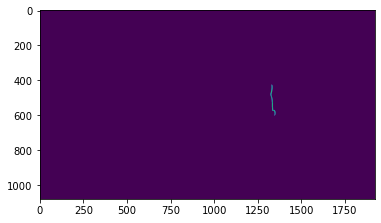

In [6]:
##On crée une fonction pour récupérer l'image sans fond. c'est à dire qu'on ne prend que le laser.
##On récup l'image puis on ne garde que le rouge de cette image puis on prend tout les points supérieur
#à 180 (qui sont rouge..)
def recupImageSansFond(LeftRight,nb):
    img=recupImage(LeftRight,nb)
    redImg = img[:,:,2]  
    ret, mask = cv2.threshold(redImg,180,255,cv2.THRESH_TOZERO)
    return mask

#on test
mask=recupImageSansFond("Left",5)
plt.imshow(mask)
plt.show()

## Fonction pour récupérer les points laser 

In [7]:
#Fonction pour récupérer tous les points laser que l'on pouvait retrouver sur l'image juste avant.
## Grace à cette fonction, on va mettre tous les pixels n'étant pas à 0 à 1 
## Ensuite on va faire une moyenne sur toute la ligne en aditionnant les pixel (0ou1) avec l'indice puis on divise par la ligne.
##Ensuite on rajoute l'index et un 1 pour des coordonnées homogènes
def recupPointsLaser(LeftRight,nb):
    imgSansFond=recupImageSansFond(LeftRight,nb)
    pointsRed=[[],[],[]]
    
    for i in range(imgSansFond.shape[0]):
        sumNotZero=0
        for j in range(imgSansFond.shape[1]):
            if(imgSansFond[i][j]>0):
                imgSansFond[i][j]=1
                sumNotZero+=1
        if (sumNotZero>0):
            #ToAppend=sum(range(imgSansFond.shape[1])*imgSansFond[i])/sum(imgSansFond[i])
            ToAppend=np.average(range(imgSansFond.shape[1]),weights=imgSansFond[i])
            pointsRed[0].append(ToAppend)
            pointsRed[1].append(i)
            pointsRed[2].append(1)
    
    return pointsRed

pointsRed=recupPointsLaser("Right",15)

## Fonction pour trouver les Epilignes

In [8]:
##On crée une fonction pour trouver les lignes épipolaires pour tous les "points laser" récupérer et pour toutes les images.

def trouverEpilignes(LeftRight, mtxFondamental):
    EpilignesLeft=[]
    
    imgsPath="scan"
    imgsPath+=LeftRight
    imgsPath+="/*.png"
    imgsInPath=glob.glob(imgsPath)
    for nbPath in range(len(imgsInPath)):
        pointsLeft = recupPointsLaser(LeftRight,nbPath)
            
        EpilignesRight = mtxFondamental @ pointsLeft
        EpilignesLeft.append([pointsLeft,EpilignesRight])
        
        ##Assez long donc on montre l'avancement
        pourcentage='working... ' + str((nbPath+1)*100/len(imgsInPath)) + '%'
        print(pourcentage, end='\r')
    
    return EpilignesLeft

#### matrix [x]x pour produit vectoriel

En géométrie projective 2D, une droite d’équation $ax+by+c = 0$ est représentée par un vecteur à trois composantes $(a, b, c)^T$ définies à un facteur près. On a donc la relation suivante:

>Le point $\vec{x}$ appartient à la droite $\vec{l}$ si et seulement si $x^T\vec{l} = 0$.

De plus, en géométrie projective 2D, les relations remarquables suivantes sont valables:

- L’intersection de deux lignes $l$ et $l'$ est donnée par $x = l \times l'$,
- La droite passant par deux points $x$ et $x'$ est donnée par $l = x \times x'$.

Notons que le produit vectoriel peut être écrit comme un produit de matrice $x \times y = [x]_\times y$ où

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

In [9]:
#Définition produit vectoriel voir ci-dessus pour l'utiliser dans l'équation pour trouver la matrice fondamentale.

def matrix_Xx(v):
    v = v[:,0]
    return np.array([[0,-v[2],v[1]], [v[2],0,-v[0]], [-v[1],v[0],0]])

## Calcul de la matrice fondamentale

La matrice fondamentale $F$ a sept degrés de liberté. Elle possède neuf composantes mais celles-ci sont définies à un facteur d’échelle près, ce qui enlève un degré de liberté. De plus, la matrice $F$ est une matrice singulière ($det(F) = 0$) ce qui nous fait bien sept degrés de liberté. Il nous faut donc sept correspondances minimum pour calculer $F$. L’équation $x'^{T}_iFx_i = 0$ et les sept correspondances nous permettent d’écrire un système d’équations de la forme $Af = 0$, où $f$ est le vecteur qui contient les composantes de la matrice $F$. Admettons que $A$ soit une matrice 7×9 de rang 7. La solution générale de $Af = 0$ peut s’écrire $\alpha f_1 + (1−\alpha) f_2$ où $f_1$ et $f_2$ sont deux solutions particulières indépendantes de $Af = 0$. On utilise ensuite la contrainte de singularité $det(\alpha F_1 + (1 − \alpha)F_2) = 0$ pour déterminer $\alpha$. La contrainte de singularité donnant lieu à une équation du troisième degré, on pourra avoir une ou trois solutions pour $F$.


Comme la ligne épipolaire $\vec{l}' = F\vec{x}$ est le lieu de $\vec{x}'$, $\vec{x}'$ appartient donc à $\vec{l}'$ ce qui conduit à la contrainte épipolaire :

>**La matrice fondamentale est telle que pour toute paire de points se correspondant $\vec{x} \leftrightarrow \vec{x}'$ dans les deux images, on a $\vec{x}'^{T}F\vec{x} = 0$.**

In [11]:
##Matrice fondamentale que l'on doit trouver pour les calculs suivants. Voir ci-dessus (grand F)
mtxFondamentale = np.array(matrix_Xx(mtxCamLeft @ posCamRight) @ mtxCamRight @ np.linalg.pinv(mtxCamLeft))

EPL = trouverEpilignes("Left", mtxFondamentale)

## Fonction pour récuperer l'Epiligne des points moyen d'une image UTILE UNIQUEMENT POUR REPRESENTATION

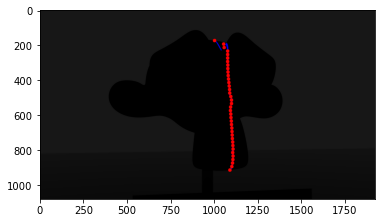

In [12]:
##Cette fonction ne sert uniquement qu'a récupérer les points moyen des lignes épopolaires afin de les afficher
def PointMoyenEpiligne(LeftRight,nb,Epilignes):
    EpiLeft=Epilignes[nb][0]
    img = recupImage(LeftRight,nb)
    i=0
    while i < len(EpiLeft[0]):
        img = cv2.circle(img,(int(EpiLeft[0][i]),int(EpiLeft[1][i])),10,[255,0,0],-1)
        i+=20
        
    return img

nb=12
LeftRight="Left"
#EPL=trouverEpilignes(LeftRight, mtxFondamentale)
plt.imshow(PointMoyenEpiligne(LeftRight,nb,EPL))
plt.show()

## Fonction pour récupérer les Epiligne UTILE UNIQUEMENT POUR REPRESENTATION

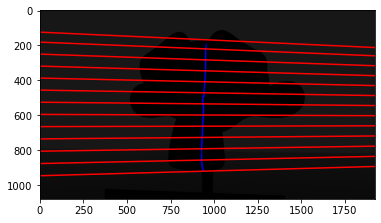

In [13]:
## Petite fonction pour transformer une équation en y=??
def Yegal(coef,x):
    a,b,c = coef
    return -(c+a*x)/b

## Cette fonction sert à dessiner toutes les lignes épipolaires (avec un nb de lignes choisi)
def dessinerEpilignes(LeftRight,nb,Epilignes,nbLignes):
    EpiRight=Epilignes[nb][1]
    img=recupImage(LeftRight,nb)
    interval=round(EpiRight.shape[1]/nbLignes)-1
    for i in range(0,EpiRight.shape[1],interval):
        #print(EpiRight)
        plt.plot([0,img.shape[1]-1],[Yegal(EpiRight[:,i],0),Yegal(EpiRight[:,i],img.shape[1]-1)],'r')
    plt.imshow(img)
    plt.show()

nbLignes=12
nb=12
LeftRight="Right"
#EPL=trouverEpilignes(LeftRight, mtxFondamentale)
dessinerEpilignes(LeftRight,nb,EPL,nbLignes)


## Fonction pour trouver points rouge sur une image 

In [14]:
##Maintenant qu'on a toutes les lignes épipolaires on peut trouver les points à droite pour ce faire on va 
##trouver tous les points "laser" à droite qui corresponde à un point d'une ligne épipolaire.
#C'est fonction est pour une image
def RedPointsOnEpilignes(LeftRight,nb,Epilignes):
    pointsRed = recupPointsLaser(LeftRight,nb)
    img=recupImage(LeftRight,nb)
    
    pointsRight=[[],[],[]]
    EpiRight=Epilignes[nb][1]
    
    for i in range(len(EpiRight[0])):
        #print(EpiRight[:,i])
        try:
            x=int(pointsRed[0][i])
            y=int(Yegal(EpiRight[:,i],x))
            
            pointsRight[0].append(x)
            pointsRight[1].append(y)
            pointsRight[2].append(1)
            
            img = cv2.circle(img,(x,y),5,[0,0,255],-1)
        except:
            pass
            
    return pointsRight, img
    

nb=12
pts=RedPointsOnEpilignes("Right",nb,EPL)

#dessinerEpilignes(LeftRight,nb,EPL,nbL)

## Fonction pour trouver points rouge sur toutes les images 

In [15]:
##Ici on va faire la même chose mais pour toutes les images
def EpiligneEtPointsRed(LeftRight, Epilignes):
    points=[]
    imgsPath="scan"
    imgsPath+=LeftRight
    imgsPath+="/*.png"
    imgsInPath=glob.glob(imgsPath)
    for nbPath in range(len(imgsInPath)):
        pointsRight,scan=RedPointsOnEpilignes(LeftRight,nbPath,Epilignes)
        
        points.append(pointsRight)
        
        pourcentage='working... ' + str((nbPath+1)*100/len(imgsInPath)) + '%'
        print(pourcentage, end='\r')
    
    return points

pointsRight=EpiligneEtPointsRed("Right", EPL)

## Fonction pour avoir l'intersection entre les rayons rétroprojetés

In [16]:
##Cette fonction sert à récupérer tous les points déintersections des rayons rétroprojeté gauche et droit. Voir ci-dessus
def recupIntersections(pointsLeft, pointsRight, posCamLeft, posCamRight, mtxCamLeft, mtxCamRight):
    pointsLeft=np.array(pointsLeft)   ##Les points "laser"
    pointsRight=np.array(pointsRight)
    
    ## centre optique en vecteur
    camLeft=np.transpose(posCamLeft)[0]
    camRight=np.transpose(posCamRight)[0]
    
    ## On prend la pseudo inverse car ce n'est pas une carré pour retomber sur les coordonné en 2D de l'objet 
    ## mtxCamLeft= mtx @ matrixRTLeft c'est F
    leftObject2D = (np.linalg.pinv(mtxCamLeft) @ pointsLeft)
    rightObject2D = (np.linalg.pinv(mtxCamRight) @ pointsRight)
    
    ## les positions des points dans le referentiel Monde
    pointsLeftRefWorld = mt.Vector((leftObject2D[0],leftObject2D[1],leftObject2D[2]))
    pointsRightRefWorld = mt.Vector((rightObject2D[0],rightObject2D[1],rightObject2D[2]))
    
    posCentreOptiqueLeft=mt.Vector((camLeft[0],camLeft[1],camLeft[2]))
    posCentreOptiqueRight=mt.Vector((camRight[0],camRight[1],camRight[2]))
    
    ##grace a mathutils on peut trouver l'intersection
    return mt.geometry.intersect_line_line(posCentreOptiqueLeft,pointsLeftRefWorld,posCentreOptiqueRight,pointsRightRefWorld)


LeftPoints=np.array(EPL[12][0])[:,2]
RightPoints=np.array(pointsRight[12])[:,2]

recupIntersections(LeftPoints, RightPoints, posCamLeft, posCamRight, mtxCamLeft, mtxCamRight)

(Vector((0.13320273160934448, 0.011145591735839844, -0.06123161315917969)),
 Vector((0.13306118547916412, 0.009120911359786987, -0.06172116845846176)))

## Fonction pour récupérer et placer les intersections dans un array

In [17]:
##On récupère les intersections et on les mets dans un array pour les dessiner ensuite

def recupPointsImageFinal(length,Epilignes, RightPoints, posCamLeft, posCamRight, mtxCamLeft, mtxCamRight):
    coord=[[],[],[]]
    for l in range(length):
        
        pointsLeft=np.array(Epilignes[l][0])
        pointsRight=np.array(RightPoints[l])
        for i in range(len(pointsLeft[0])):
            try:
                intersection = recupIntersections(pointsLeft[:,i], pointsRight[:,i], posCamLeft, posCamRight, mtxCamLeft, mtxCamRight) 
                for inter in intersection:                                                   
                    x,y,z = inter                                                       
                    coord[0].append(x)
                    coord[1].append(y)
                    coord[2].append(z)
            except:
                pass
    
    return np.array(coord)
    
points=recupPointsImageFinal(26,EPL,pointsRight, posCamLeft, posCamRight, mtxCamLeft, mtxCamRight)

## Fonction pour dessiner ces points 

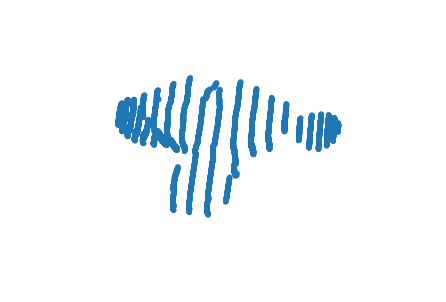

In [18]:
##On représente les points

def representationDesPoints(points):
    figure=plt.figure()
    ax=Axes3D(figure)
    ax.scatter3D(points[0,:],points[1,:],points[2,:])
    
    ax.view_init(90,90)
    plt.axis('off')
    plt.show()
    
representationDesPoints(points)

## Fonction qui marche pas mais qui devrait dessiner

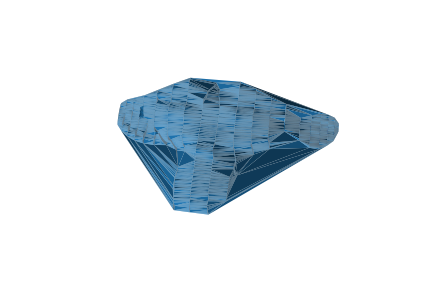

In [19]:
def drawSurfaceObject(point):
    figure = plt.figure()
    ax = Axes3D(figure)
    ax.plot_trisurf(point[0,:],point[1,:],point[2,:])     

    ax.view_init(90,90)
    plt.axis('off')
    plt.show()
    
drawSurfaceObject(points)